<a href="https://colab.research.google.com/github/rht6226/InnoHAR-NeuralNet/blob/master/InnoHAR_optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the Preprocessed UCI HAR Mobile Dataset

In [4]:
import numpy as np
from keras.utils import to_categorical
import json
import matplotlib

In [5]:
class UciMobileDataset:
    def __init__(self, filepath):
        with np.load(filepath + 'uci.npz') as data:
            self.trainX = data['trainX']
            self.trainy = to_categorical(data['trainy'])
            self.testX = data['testX']
            self.testy = to_categorical(data['testy'])

    def summary(self):
        print("UCI Human Activity Recognition Dataset: ")
        print("Shape of training data = X:{}, y: {}".format(self.trainX.shape, self.trainy.shape))
        print("Shape of testing data = X:{}, y: {}".format(self.testX.shape, self.testy.shape))

In [6]:
uci = UciMobileDataset(filepath='/content/drive/My Drive/HAR Processed Data/UCI_HAR/')
uci.summary()

UCI Human Activity Recognition Dataset: 
Shape of training data = X:(7352, 128, 9), y: (7352, 6)
Shape of testing data = X:(2947, 128, 9), y: (2947, 6)


# Inception based Model With GRU Layer

## Model Training

In [7]:
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import MaxPooling1D, Conv1D, Flatten, Dense, Concatenate, GRU, Input, InputLayer
from keras.utils.vis_utils import plot_model

In [8]:
class Incept1D(keras.Model):
    def __init__(self, c1, c2, c3, c4):
        super(Incept1D, self).__init__()
        self.p1_1x1_conv = Conv1D(filters=c1, kernel_size=1, activation='relu', padding='same')

        self.p2_1x1_conv = Conv1D(filters=c2[0], kernel_size=1, activation='relu', padding='same')
        self.p2_1x3_conv = Conv1D(filters=c2[1], kernel_size=3, activation='relu', padding='same')

        self.p3_1x1_conv = Conv1D(filters=c3[0], kernel_size=1, activation='relu', padding='same')
        self.p3_1x5_conv = Conv1D(filters=c3[1], kernel_size=3, activation='relu', padding='same')

        self.p4_1x3_maxpool = MaxPooling1D(pool_size=3, strides=1, padding='same')
        self.p4_1x1_conv = Conv1D(filters=c4, kernel_size=1, padding='same', activation='relu')


    def call(self, x):
        p1 = self.p1_1x1_conv(x)
        p2 = self.p2_1x3_conv(self.p2_1x1_conv(x))
        p3 = self.p3_1x5_conv(self.p3_1x1_conv(x))
        p4 = self.p4_1x1_conv(self.p4_1x3_maxpool(x))
        # Concatenate the outputs on the channel dimension
        return Concatenate()([p1, p2, p3, p4])

In [9]:
def get_model(trainX, trainy):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

    # Model Definitions
    model = Sequential()
    # Input Layer
    model.add(InputLayer(input_shape=(n_timesteps, n_features)))
    model.add(Incept1D(64, (32, 64), (32, 64), 64))
    model.add(Incept1D(56, (32, 64), (32, 64), 64))
    model.add(Incept1D(32, (32, 56), (32, 56), 32))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Incept1D(32, (16, 32), (16, 32), 24))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(GRU(120, return_sequences=True))
    model.add(GRU(40))
    model.add(Dense(n_outputs, activation='softmax',
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
                    bias_regularizer=regularizers.l2(1e-4), 
                    activity_regularizer=regularizers.l2(1e-5)
                    ))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print stuff
    print(model.summary())
    return model

In [25]:
model = get_model(uci.trainX, uci.trainy)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
incept1d_4 (Incept1D)        (None, 128, 256)          14336     
_________________________________________________________________
incept1d_5 (Incept1D)        (None, 128, 248)          59704     
_________________________________________________________________
incept1d_6 (Incept1D)        (None, 128, 176)          42736     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 64, 176)           0         
_________________________________________________________________
incept1d_7 (Incept1D)        (None, 64, 120)           18712     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 32, 120)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 32, 120)          

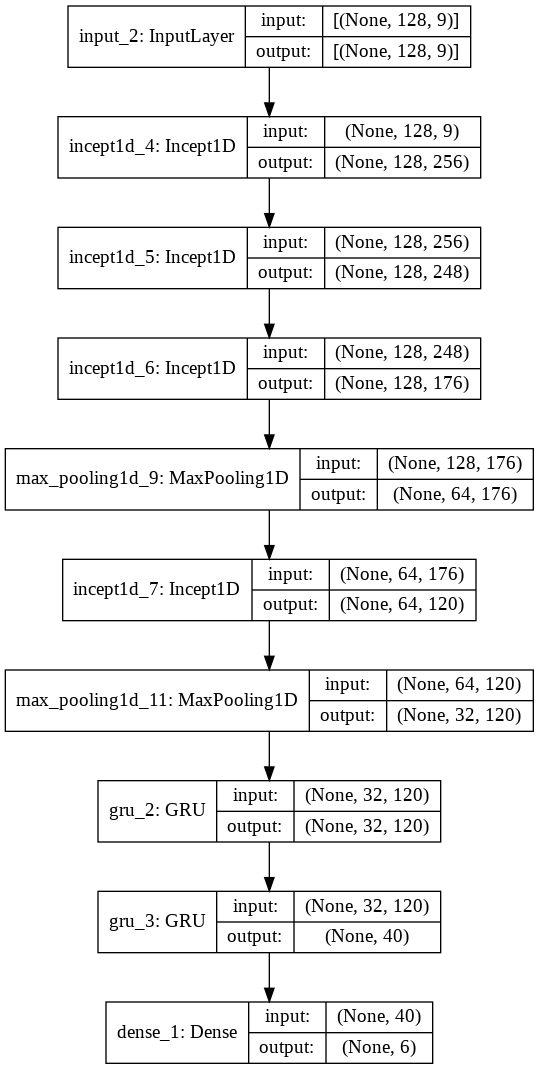

In [26]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [27]:
history_inception = model.fit(x=uci.trainX, y=uci.trainy, validation_data=(uci.testX, uci.testy), verbose=1, batch_size=64, epochs=30)

Epoch 1/30
115/115 [==============================] - 7s 32ms/step - loss: 0.9610 - accuracy: 0.5856 - val_loss: 0.3864 - val_accuracy: 0.8683
Epoch 2/30
115/115 [==============================] - 2s 20ms/step - loss: 0.1908 - accuracy: 0.9357 - val_loss: 0.2670 - val_accuracy: 0.9070
Epoch 3/30
115/115 [==============================] - 2s 20ms/step - loss: 0.1293 - accuracy: 0.9516 - val_loss: 0.3204 - val_accuracy: 0.8846
Epoch 4/30
115/115 [==============================] - 2s 20ms/step - loss: 0.1239 - accuracy: 0.9459 - val_loss: 0.4481 - val_accuracy: 0.8717
Epoch 5/30
115/115 [==============================] - 2s 20ms/step - loss: 0.1277 - accuracy: 0.9455 - val_loss: 0.2518 - val_accuracy: 0.9158
Epoch 6/30
115/115 [==============================] - 2s 20ms/step - loss: 0.1110 - accuracy: 0.9566 - val_loss: 0.2213 - val_accuracy: 0.9199
Epoch 7/30
115/115 [==============================] - 2s 20ms/step - loss: 0.1060 - accuracy: 0.9552 - val_loss: 0.2318 - val_accuracy: 0.9260

In [13]:
# Saving the model
import tensorflow as tf    
tf.keras.models.save_model(
    model,
    "Inception_GRU_UCI_HAR.model",
    overwrite=True,
    include_optimizer=True
) 

INFO:tensorflow:Assets written to: Inception_GRU_UCI_HAR.model/assets


INFO:tensorflow:Assets written to: Inception_GRU_UCI_HAR.model/assets


In [30]:
_, accuracy = model.evaluate(uci.testX, uci.testy, batch_size=64, verbose=1)
print("Accuracy for Inception and GRU based model = {}%".format(accuracy))

47/47 [==============================] - 0s 9ms/step - loss: 0.2614 - accuracy: 0.9237
Accuracy for Inception and GRU based model = 0.9236511588096619%


## Plotting Accuracy

In [31]:
# Plotting Loss and Accuracy

import matplotlib.pyplot as plt

def plot_model_accuracy(details, history, figureSize=[8, 8]):
    matplotlib.rcParams['figure.figsize'] = figureSize
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy for {}'.format(details))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_model_loss(details, history, figureSize=[8, 8]):
    matplotlib.rcParams['figure.figsize'] = figureSize
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss for {}'.format(details))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

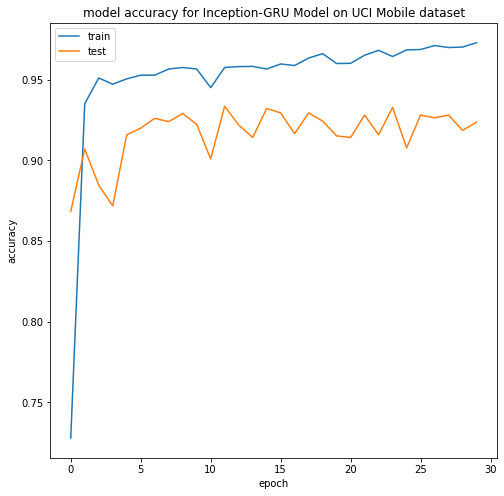

In [32]:
plot_model_accuracy("Inception-GRU Model on UCI Mobile dataset", history=history_inception)

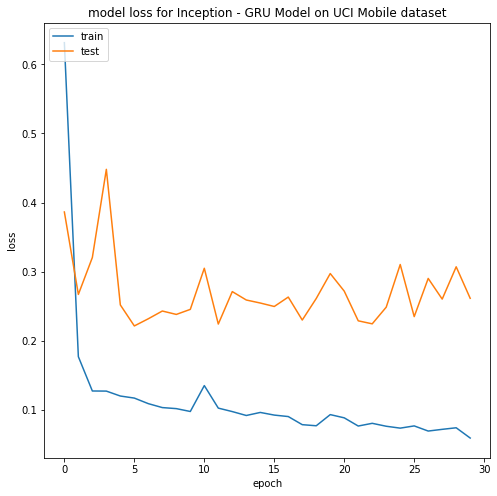

In [33]:
plot_model_loss("Inception - GRU Model on UCI Mobile dataset", history=history_inception)

## Plotting Confusion Matrix

In [34]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [35]:
def plot_cm(predictedY, testy, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, figureSize=[10, 10]):
    matplotlib.rcParams['figure.figsize'] = figureSize
    # Predict Y, And get Confusion Matrix
    predictedY = np.argmax(predictedY, axis = 1)
    testy = np.argmax(testy, axis=1)
    cm = confusion_matrix(y_true=testy, y_pred=predictedY)

    # Plotting
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


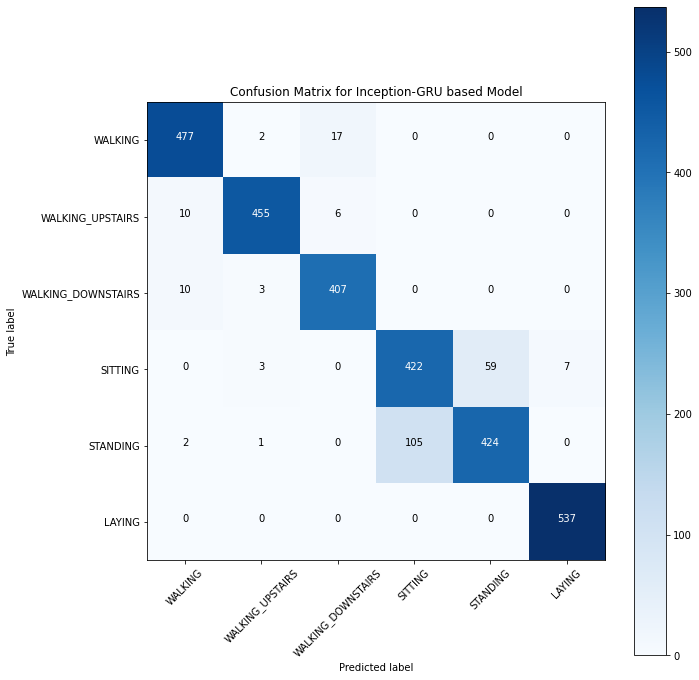

In [36]:
# Inception- GRU based network
predictedY = model.predict(uci.testX)
cm_plot_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
plot_cm(predictedY, testy=uci.testy, classes=cm_plot_labels, title='Confusion Matrix for Inception-GRU based Model')

## Classification Report

In [21]:
from sklearn.metrics import classification_report

In [29]:
# 1D CNN based Model
predictedY = model.predict(uci.testX)
y_pred = np.argmax(predictedY, axis = 1)
y_true = np.argmax(uci.testy, axis=1)
target_names = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
print("Incepion-GRU based Model: \n")
print(classification_report(y_true, y_pred, target_names=target_names, digits=5))

Incepion-GRU based Model: 

                    precision    recall  f1-score   support

           WALKING    0.95591   0.96169   0.95879       496
  WALKING_UPSTAIRS    0.98060   0.96603   0.97326       471
WALKING_DOWNSTAIRS    0.94651   0.96905   0.95765       420
           SITTING    0.80076   0.85947   0.82908       491
          STANDING    0.87785   0.79699   0.83547       532
            LAYING    0.98713   1.00000   0.99352       537

          accuracy                        0.92365      2947
         macro avg    0.92479   0.92554   0.92463      2947
      weighted avg    0.92426   0.92365   0.92340      2947



## Overall accuracy using Weighted F-Beta Score

In [37]:
from sklearn.metrics import precision_recall_fscore_support as score

In [38]:
predictedY = model.predict(uci.testX)
y_pred = np.argmax(predictedY, axis = 1)
y_true = np.argmax(uci.testy, axis=1)

precision,recall,fscore, _ = score(y_true,y_pred,average='macro')
print ('Precision : {}'.format(precision))
print ('Recall    : {}'.format(recall))
print ('F-score   : {}'.format(fscore))


Precision : 0.9247941761573851
Recall    : 0.9255389735101671
F-score   : 0.9246286960362711
